<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/DBSCAN/DBSCAN_3293_DR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


In [ ]:
!pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 8.3 MB/s 
     |████████████████████████████████| 832 kB 14.6 MB/s 
     |████████████████████████████████| 48 kB 5.8 MB/s 
     |████████████████████████████████| 4.0 MB 13.2 MB/s 


In [ ]:

# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier



## Necessary Functions

### Loading the data

In [ ]:
def get_GAIA_data(name, radius = 1, table = 'gaiadr3.gaia_source', 
                  search = True, preprocess = True, *args, **kwargs):
    '''
    Collects the data from GAIA Archive for the given object by conesearch within
    a given radius from a given table. Then preprocessed the data to remove noisy
    data and to apply other cutoffs (i.e., |pm| < 20 mas/yr )
    '''

    if search:
        # conesearch using the object name and radius
        coordinate = coord.SkyCoord.from_name(name)
        print(f'Object Name: {name}')
        print('Co-ordinate', coordinate)

        radius = u.Quantity(radius, u.deg)
        Gaia.ROW_LIMIT = -1
        table = table
        j = Gaia.cone_search_async(coordinate, radius, table_name = table)
        r = j.get_results()

        all_stars = r.to_pandas()
        print(f'Total Raw Stars: {len(all_stars)}')

    #print(all_stars.head())

    ## plotting the skyplot 
    sns.set(rc={'figure.figsize':(8.7,6.27)})
    skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
    skyplot.invert_xaxis()
    plt.title('Skyplot of GAIA data')
    plt.show()

    if preprocess:
        ## magnitude error
        ## del magnitude = - 2.5 log(del Flux / Flux)
        all_stars['g_mag_error'] = 2.5/np.log(10) / all_stars.phot_g_mean_flux_over_error

        mask = (all_stars.parallax_over_error >= 3) & (all_stars.pmra_error < 1) \
                & (all_stars.pmdec_error < 1) & (all_stars.ruwe < 1.4)

        all_stars = all_stars.loc[mask, :]
        print(f'Number of stars after applying noise filter: {len(all_stars)}')

        # calculating the distance from the parallax
        all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

        # positive parallax
        all_stars = all_stars[all_stars['parallax'] >= 0]

        # dropping rows with null values in required columns
        all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
        all_stars = all_stars[all_stars.loc[:, 'parallax'].notnull()]
        all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]

        # defining proper motion (pm) range
        all_stars = all_stars[(abs(all_stars['pmra']) < 20) & (abs(all_stars['pmdec']) < 20)]

        # taking stars within 30' = 0.5 deg radius
        # all_stars = all_stars[all_stars['dist'] < (30/60)]
        print(f'Number of stars after applying other filters: {len(all_stars)}')
    
    return all_stars

In [ ]:
def get_normalized_feature(all_stars, feature_columns = ['pmra', 'pmdec', 'parallax']):
    # selecting the features
    features = all_stars.loc[:, feature_columns]
    features = features.dropna()

    # normalizing the features
    scaled_features = pd.DataFrame({})
    for column in features.columns:
        scaled_features[column] = (features[column] - np.median(features[column]))/np.std(features[column])
    
    return scaled_features

### Getting MNN and MSS Values

In [ ]:
def get_members(all_stars, scaled_features, eps, min_sample):
    db = DBSCAN(eps= eps,min_samples= min_sample).fit(scaled_features)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    all_stars['labels'] = labels
    all_stars['is_core'] = core_samples_mask

    member, non_member = all_stars[all_stars.labels == 0],\
                         all_stars[all_stars.labels == -1]
    return member, non_member


In [ ]:
def mean_nearest_neighbor(member_data, feature_columns = ['pmra', 'pmdec', 'parallax']):
    '''
    returns the average of the nearest neighbor distance for all the member stars
    ''' 

    # normalizing the features 
    scaled_member_features = get_normalized_feature(member_data, feature_columns)

    nn_model = NearestNeighbors(n_neighbors=2) # model to find 1st nearest neighbor

    nn_members = nn_model.fit(scaled_member_features)        # training the model using normalized dataset 

    nn_distances, nn_indices = nn_members.kneighbors(scaled_member_features) #[(distance, index of the 30th nearest neighbor)]

    mnn = np.mean(nn_distances[:, 1])

    return mnn


In [ ]:
def get_MSS_metric(member, non_member, epsilon = 1e-7, 
                   feature_columns = ['pmra', 'pmdec', 'parallax']):
    '''
    Returns the Modified Silhouttee Score for given member and non_member data
    '''
    if len(member) < 2 or len(non_member) < 2:
        return 0

    metric = np.zeros(len(feature_columns))
    for i in range(len(feature_columns)):
        feature_i = feature_columns[i]
        # (field_SD - member SD)/max(field_SD, member SD, epsilon) for each features
        metric[i] = (np.std(non_member[feature_i]) - np.std(member[feature_i])) \
                / max(np.std(member[feature_i]), np.std(non_member[feature_i]), epsilon)
    
    mss_metric = metric.mean()
    return mss_metric

In [ ]:
def compare_DBSCAN_parameters(all_stars, scaled_features, 
                              eps, min_samples):

    # running DBSCAN with all possible parameters
    mnn_values = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')
    n_members = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')
    mss_metrics = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')

    for i in range(len(eps)):
        ep = eps[i]
        for j in range(len(min_samples)):
            min_sample = min_samples[j]

            member, non_member = get_members(all_stars, scaled_features, ep, min_sample)
            try:
                mnn_values[i,j] = mean_nearest_neighbor(member)
            # if there is any error comes up, we will continue the program by keeping -1 as the MNN value
            except: 
                pass
            mss_metrics[i,j] = get_MSS_metric(member, non_member)
            n_members[i,j] = len(member)

    # Creating a DataFrame with paramters and metrics
    model_parameters = pd.DataFrame({'eps': np.repeat(eps, len(min_samples)),
                        'min_sample': np.tile(min_samples, len(eps)),
                        'mnn': mnn_values.flatten(),
                        'mss': mss_metrics.flatten(), 
                        'n_member' : n_members.flatten()})
                      
    model_parameters = model_parameters[model_parameters.mnn > 0] # removing the rows where MNN is negative
    

    # Visualize the change in metric values
    plt.figure(figsize = (20,6))

    plt.subplot(131)
    sns.lineplot(x='eps', y='mnn', hue = 'min_sample', data = model_parameters, 
                 legend = 'full')

    plt.subplot(132)
    sns.lineplot(x='eps', y='mss', hue = 'min_sample', data = model_parameters, 
                 legend = 'full')

    plt.subplot(133)
    sns.lineplot(x='eps', y='n_member', hue = 'min_sample', data = model_parameters, 
                 legend = 'full')
    plt.show()

    return model_parameters

### Additional Function for Comparing with Cantat

In [ ]:
def get_cantat_data(data = 'member', clusters = None):
    if data == 'cluster':
        if clusters == None:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/table1', 
                             row_limit = -1).query_constraints()
        else:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/table1', 
                                row_limit = -1).query_constraints(Cluster = clusters)
        cantat_data = cantat_data[0].to_pandas()
        return cantat_data

    if data == 'member':
        if clusters == None:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/members', 
                             row_limit = -1).query_constraints()
        else:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/members', 
                                row_limit = -1).query_constraints(Cluster = clusters)
        cantat_data = cantat_data[0].to_pandas()

        # renaming the cantat table to match it with gaia_data
        cantat_data = cantat_data.rename(columns={'Source':'source_id',
                                                'Proba':'PMemb',
                                                'RA_ICRS': 'ra',
                                                'DE_ICRS': 'dec',
                                                'pmRA': 'pmra',
                                                'pmDE': 'pmdec',
                                                'Gmag': 'phot_g_mean_mag',
                                                'BP-RP': 'bp_rp',
                                                'Plx': 'parallax'})
        
        return cantat_data


In [ ]:
def get_rf_member(cluster_name):
    rf_data = pd.read_csv('https://raw.githubusercontent.com/mahmud-nobe/Cluster-Membership/master/all_possible_members.csv', index_col=0)
    rf_member = rf_data[rf_data.cluster == cluster_name]

    if len(rf_member) == 0:
        print(f'The cluster, {cluster_name}, is not present in RF data.\n')
    return rf_member

In [ ]:
def compare_with_cantat_rf(cluster_name, dbscan_member, cantat_member, rf_member):

    concatenated = pd.concat([dbscan_member.assign(dataset='DBSCAN'), 
                            cantat_member.assign(dataset='Cantat'),
                            rf_member.assign(dataset = 'RF')])
    # concatenated.reset_index(drop=True)
    print(f'Cluster: {cluster_name}')
    print(concatenated.dataset.value_counts())
    print(f'Cantat (PMemb > 0.5): {sum(cantat_member.PMemb > 0.5)}')
    print('\n')

    fig, axes = plt.subplots(1, 3, figsize=(20,6))
    fig.suptitle(f"Distribution of the Cantat and predicted Members of {cluster_name.replace('_', ' ')}")


    sns.distplot(dbscan_member['parallax'], color = 'tab:purple', label = 'RF', 
                kde=True, ax=axes[0])
    sns.distplot(cantat_member['parallax'], color = 'tab:orange', label = 'Cantat', 
                kde=True, ax=axes[0])
    sns.distplot(dbscan_member['parallax'], color = 'tab:green', label = 'DBSCAN', 
                kde=True, ax=axes[0])
    axes[0].set_title('Parallax Distribution')
    axes[0].legend()

    
    sns.distplot(dbscan_member['pmra'], color = 'tab:purple', label = 'RF', 
                kde=True, ax=axes[1])
    sns.distplot(cantat_member['pmra'], color = 'tab:orange', label = 'Cantat', 
                kde=True, ax=axes[1])
    sns.distplot(dbscan_member['pmra'], color = 'tab:green', label = 'DBSCAN', 
                kde=True, ax=axes[1])
    axes[1].set_title('pmra Distribution')
    axes[1].legend()

    sns.distplot(dbscan_member['pmdec'], color = 'tab:purple', label = 'RF', 
                kde=True, ax=axes[2])
    sns.distplot(cantat_member['pmdec'], color = 'tab:orange', label = 'Cantat', 
                kde=True, ax=axes[2])
    sns.distplot(dbscan_member['pmdec'], color = 'tab:green', label = 'DBSCAN', 
                kde=True, ax=axes[2])
    axes[2].set_title('pmdec Distribution')
    axes[2].legend()

    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(22,6))
    fig.suptitle(f"Predicted Members and Cantat Members of {cluster_name.replace('_', ' ')}")

    skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                    hue='dataset', ax=axes[0], palette = 'Dark2')
    axes[0].set_title('Sky plot')

    # proper motion plot
    sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                    hue='dataset', ax=axes[1], palette = 'Dark2')
    axes[1].set_title('Proper motion plot')

    cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                    hue='dataset', ax=axes[2], palette = 'Dark2')
    cmd.invert_yaxis()
    axes[2].set_title('CMD')

    plt.show()


## Running it for NGC 3293

Object Name: NGC_3293
Co-ordinate <SkyCoord (ICRS): (ra, dec) in deg
    (158.97, -58.231)>
INFO: Query finished. [astroquery.utils.tap.core]
Total Raw Stars: 122940


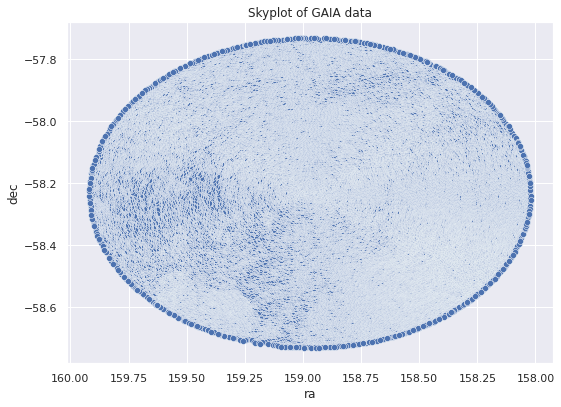

Number of stars after applying noise filter: 28855
Number of stars after applying other filters: 27552


In [ ]:
cluster_name = 'NGC_3293'
all_stars = get_GAIA_data(cluster_name, radius = 0.5)

In [ ]:
scaled_features = get_normalized_feature(all_stars)
scaled_features.head()

,pmra,pmdec,parallax
1,-0.241673,0.069100,-0.153596
3,-0.268633,0.097537,-0.232148
7,0.603483,-0.777410,-0.120795
18,-0.284100,0.142431,-0.137900
19,-0.260941,0.153271,-0.217148


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **

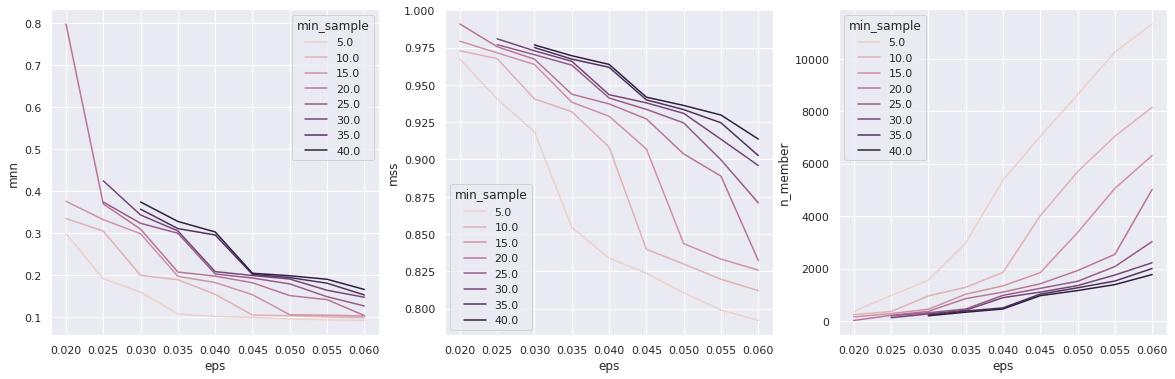

,eps,min_sample,mnn,mss,n_member
0,0.020,5.0,0.298324,0.967386,362.0
1,0.020,10.0,0.334510,0.972930,243.0
2,0.020,15.0,0.375570,0.979326,154.0
3,0.020,20.0,0.798383,0.990908,20.0
8,0.025,5.0,0.190897,0.940555,969.0


In [ ]:
eps = np.linspace(0.02,0.06,9) # you can modify the range
min_samples = np.linspace(5,40,8) # you can modify the range
model_parameters = compare_DBSCAN_parameters(all_stars, scaled_features, eps, min_samples)
model_parameters.head()

## Select the Hyperparameter

Using the above three plots, select the suitable value for eps and min_sample.

Note that, we want to have low value for MNN, high value for MSS and a reasonable number of members.

In [ ]:
best_eps =   # your code here
best_min_sample =  # your code here

member, non_member = get_members(all_stars, scaled_features, best_eps, best_min_sample)


In [ ]:
best_MSS = get_MSS_metric(member, non_member)
best_MNN = mean_nearest_neighbor(member)
best_n_member = len(member)
print(f'Mean Nearest Neighbor distance: {best_MNN}, \nModified Silhouette Score: {best_MSS}, \nNumber of Member: {best_n_member}')

### Compare with Cantat and RF

In [ ]:
cantat_member = get_cantat_data(clusters = cluster_name)

In [ ]:
rf_member = get_rf_member(cluster_name)

Cluster: NGC_3293
DBSCAN    3031
RF        1706
Cantat     657
Name: dataset, dtype: int64
Cantat (PMemb > 0.5): 370




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

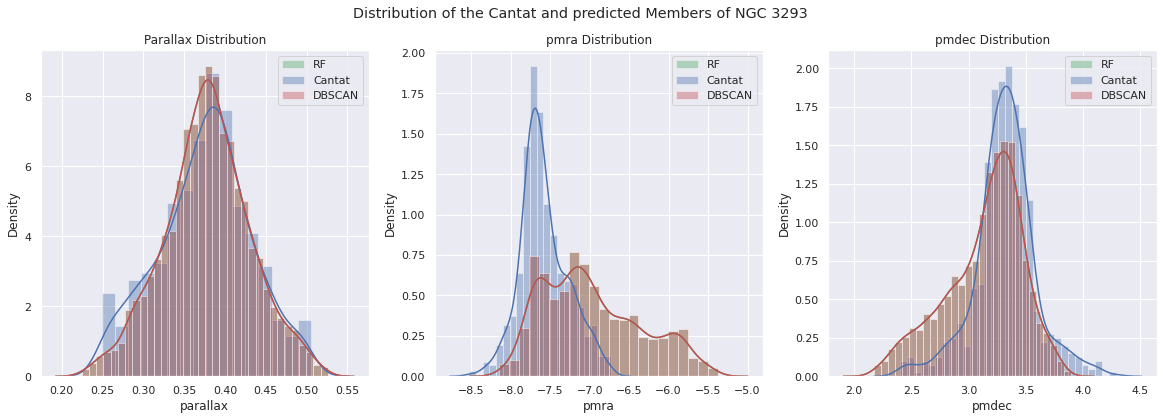

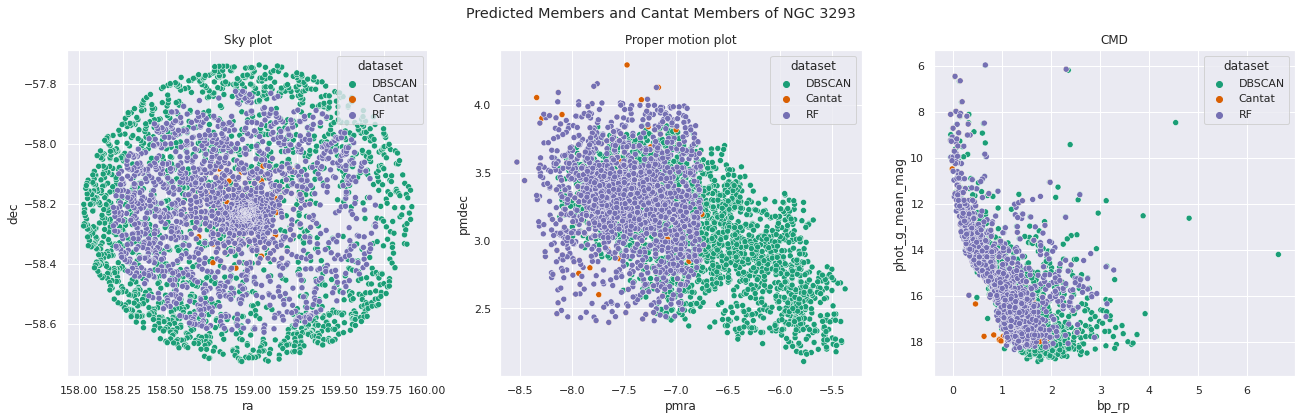

In [ ]:
compare_with_cantat_rf(cluster_name, member, cantat_member, rf_member)

## Saving the members as CSV

In [ ]:
# for downloading file
from google.colab import files
member.to_csv(f'{cluster_name}_dbscan_member.csv') # saved it in a csv

In [ ]:
files.download(f'{cluster_name}_dbscan_member.csv') # download in local computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Extra Codes (from before)

In [ ]:
## making a GAIA cone_search of 60m radius around NGC3293 center

coordinate = coord.SkyCoord.from_name('NGC3293')
print(coordinate)
radius = u.Quantity(1, u.deg)/3
Gaia.ROW_LIMIT = -1
# DR3
j = Gaia.cone_search_async(coordinate, radius, table_name="gaiadr3.gaia_source")
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (158.97, -58.231)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [ ]:
## Save the ASCII table as a data frame
all_stars = r.to_pandas()
all_stars

,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
0,1636148068921376768,Gaia DR3 5351448509738588544,5351448509738588544,1590350266,2016.0,158.969822,0.927413,-58.231358,0.903252,0.780001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.000368
1,1636148068921376768,Gaia DR3 5351448509755016832,5351448509755016832,1616156073,2016.0,158.970897,0.016117,-58.230469,0.016379,0.414998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.000710
2,1636148068921376768,Gaia DR3 5351448509738585472,5351448509738585472,1616324747,2016.0,158.968207,0.604925,-58.231943,0.686764,-2.776179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.001336
3,1636148068921376768,Gaia DR3 5351448505437778944,5351448505437778944,910140701,2016.0,158.969394,0.018871,-58.229695,0.018958,0.380763,...,0.8087,0.9487,0.8092,0.7364,0.8685,0.4334,0.3945,0.4652,A,0.001350
4,1636148068921376768,Gaia DR3 5351448509755016704,5351448509755016704,1624053996,2016.0,158.971243,0.027011,-58.232472,0.026413,1.579242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.001605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52194,1636148068921376768,Gaia DR3 5351549454347491328,5351549454347491328,1459102721,2016.0,158.769907,0.259290,-57.914928,0.244501,0.056299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.333321
52195,1636148068921376768,Gaia DR3 5351417890908287616,5351417890908287616,1023885815,2016.0,158.551025,0.038140,-58.481575,0.039856,0.303683,...,2.1537,2.1777,1.7821,1.7721,1.7941,0.9692,0.9637,0.9760,PHOENIX,0.333323
52196,1636148068921376768,Gaia DR3 5350680634000450048,5350680634000450048,924201998,2016.0,159.524146,0.103447,-58.393422,0.102489,0.528561,...,0.0011,0.0151,0.0038,0.0007,0.0109,0.0020,0.0004,0.0059,PHOENIX,0.333326
52197,1636148068921376768,Gaia DR3 5351418925996375296,5351418925996375296,506229568,2016.0,158.482983,0.340966,-58.444909,0.377486,0.597522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.333331


In [ ]:
all_stars.ruwe

0        1.475211
1        1.047261
2        1.792100
3        1.010189
4        2.052188
           ...   
52194    1.065612
52195    1.130581
52196    0.998273
52197    1.043990
52198    1.051424
Name: ruwe, Length: 52199, dtype: float32

In [ ]:
ruwe_filter = all_stars.ruwe < 1.4

In [ ]:
## magnitude error
all_stars['g_mag_error'] = 2.5/np.log(10) / all_stars.phot_g_mean_flux_over_error

In [ ]:
all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [ ]:
len(all_stars_filtered)

13632

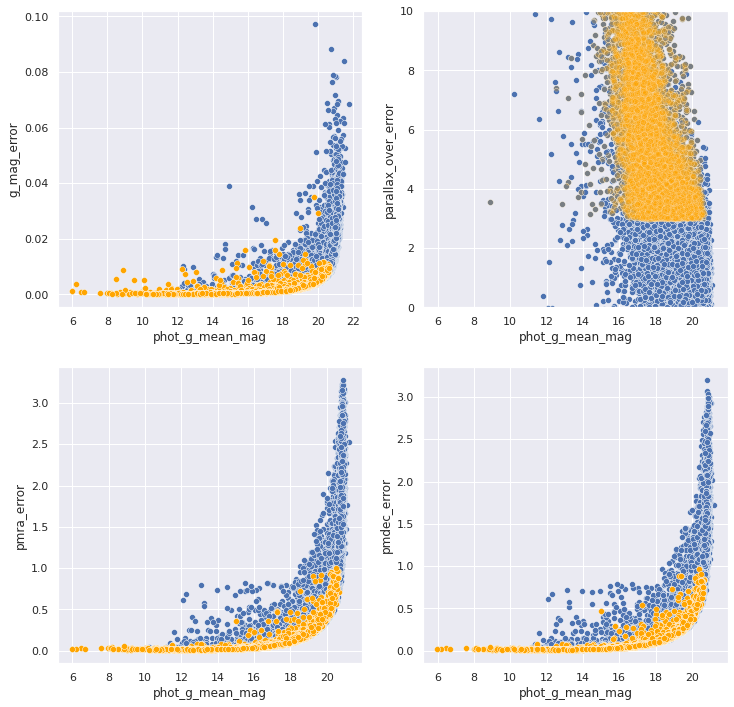

In [ ]:
## Remove data with large noise 

#ruwe_filter = all_stars.ruwe < 1.4
#mask = all_stars.parallax_over_error >= 3
#mask = (all_stars.g_mag_error <= 0.005)
mask = (all_stars.parallax_over_error >= 3) & (all_stars.pmra_error < 1) & (all_stars.pmdec_error < 1) & (all_stars.ruwe < 1.4)

plt.figure(figsize = (12,12))
plt.subplot(221)
sns.scatterplot(x=all_stars.phot_g_mean_mag, y=all_stars.g_mag_error, color = 'b')
sns.scatterplot(x=all_stars[mask].phot_g_mean_mag, y=all_stars[mask].g_mag_error, color = 'orange')

plt.subplot(222)
sns.scatterplot(x=all_stars.phot_g_mean_mag, y=all_stars.parallax_over_error, color = 'b')
sns.scatterplot(x=all_stars[mask].phot_g_mean_mag, y=all_stars[mask].parallax_over_error, color = 'orange', alpha = 0.25)
plt.ylim(0,10)


plt.subplot(223)
sns.scatterplot(x=all_stars.phot_g_mean_mag, y=all_stars.pmra_error, color = 'b')
sns.scatterplot(x=all_stars[mask].phot_g_mean_mag, y=all_stars[mask].pmra_error, color = 'orange')

plt.subplot(224)
sns.scatterplot(x=all_stars.phot_g_mean_mag, y=all_stars.pmdec_error, color = 'b')
sns.scatterplot(x=all_stars[mask].phot_g_mean_mag, y=all_stars[mask].pmdec_error, color = 'orange')
plt.show()

In [ ]:
all_stars_filtered = all_stars[mask]

In [ ]:
len(all_stars_filtered)

12705

In [ ]:
features = all_stars_filtered.loc[:, ['pmra', 'pmdec', 'parallax']]

In [ ]:
features = all_stars_filtered.loc[:, ['pmra', 'pmdec', 'parallax']]
features

,pmra,pmdec,parallax
1,-7.692861,3.247277,0.414998
3,-7.790891,3.327559,0.380763
5,-6.289207,1.255207,0.909725
6,-26.999138,30.756900,6.572805
7,-4.619843,0.857460,0.429294
...,...,...,...
52190,-4.996321,-0.374412,0.476776
52191,-8.004699,0.837689,0.768053
52193,-5.764603,3.085954,0.437348
52195,-6.713566,3.033437,0.303683


,pmra,pmdec,parallax
1,-0.136212,0.033627,-0.142548
3,-0.154373,0.053310,-0.206135
5,0.123833,-0.454772,0.776330
6,-3.712948,6.778221,11.294615
7,0.433104,-0.552289,-0.115995
...,...,...,...
52190,0.363357,-0.854310,-0.027805
52191,-0.193984,-0.557136,0.513197
52193,0.221023,-0.005924,-0.101037
52195,0.045215,-0.018800,-0.349298


In [ ]:
db = DBSCAN(eps=0.055,min_samples=30).fit(features)

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [ ]:
neigh = NearestNeighbors(n_neighbors=30)
nbrs = neigh.fit(scaled_features)
distances, indices = nbrs.kneighbors(scaled_features)
distances = np.sort(distances, axis=0)


In [ ]:
distances[1]

array([0.        , 0.00111227, 0.00330396, 0.00453824, 0.00608501,
       0.00643763, 0.00759311, 0.00831856, 0.00859447, 0.00901784,
       0.01024546, 0.01048892, 0.01187793, 0.01260746, 0.01279056,
       0.01301329, 0.01391415, 0.01416952, 0.01459752, 0.01481192,
       0.0152205 , 0.01549533, 0.01566806, 0.01577633, 0.01634059,
       0.01638547, 0.01680138, 0.01723601, 0.01768513, 0.0177856 ])

In [ ]:
distances[:,1]


array([1.11226580e-03, 1.11226580e-03, 1.91923748e-03, ...,
       6.69739287e+00, 6.80310547e+00, 6.98007163e+00])

In [ ]:
distances
dist_1 = distances[:,1]

dist_10 = distances[:, 10]

dist_ = distances[:, 10]


(0.0, 0.06)

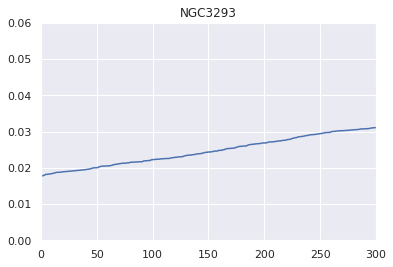

In [ ]:
plt.plot(distances[:, 29])
plt.xlim(0, 300)
#plt.yscale('log')
plt.title('NGC3293')
plt.ylim(0,0.06)

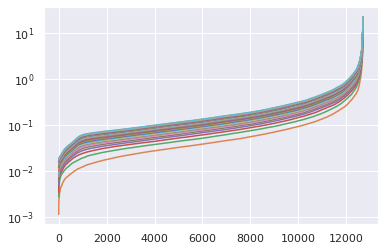

In [ ]:
plt.plot(distances)
plt.yscale('log')

(0.0, 1.0)

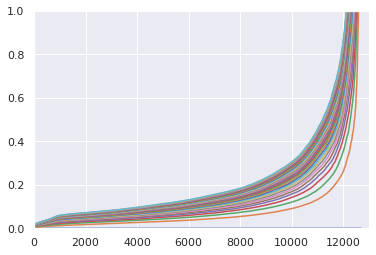

In [ ]:
plt.plot(distances)
plt.xlim([0,13000])
plt.ylim([0,1])

In [ ]:
len(scaled_features)


12705

In [ ]:
import numpy as np
eps = np.linspace(0.02,0.06,9)
eps

array([0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 , 0.055, 0.06 ])

In [ ]:
min_samples = np.linspace(5,40,8)
min_samples

array([ 5., 10., 15., 20., 25., 30., 35., 40.])

In [ ]:
member.head()

,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist,g_mag_error,labels,is_core
1,1636148068921376768,Gaia DR3 5351448509755016832,5351448509755016832,1616156073,2016.0,158.970897,0.016117,-58.230469,0.016379,0.414998,...,NaN,NaN,NaN,NaN,NaN,,0.000710,0.000439,0,True
3,1636148068921376768,Gaia DR3 5351448505437778944,5351448505437778944,910140701,2016.0,158.969394,0.018871,-58.229695,0.018958,0.380763,...,0.7364,0.8685,0.4334,0.3945,0.4652,A,0.001350,0.000436,0,True
18,1636148068921376768,Gaia DR3 5351448509755017728,5351448509755017728,1632139754,2016.0,158.977705,0.016078,-58.230215,0.016784,0.421839,...,NaN,NaN,NaN,NaN,NaN,,0.004126,0.000555,0,True
19,1636148068921376768,Gaia DR3 5351448505437777280,5351448505437777280,1423730232,2016.0,158.965519,0.016377,-58.227545,0.015643,0.387300,...,0.6024,0.6065,0.3248,0.3236,0.3259,A,0.004191,0.000229,0,True
28,1636148068921376768,Gaia DR3 5351448505437776896,5351448505437776896,1559549151,2016.0,158.964860,0.055362,-58.226442,0.054317,0.311835,...,0.8981,1.0169,0.5325,0.4968,0.5629,PHOENIX,0.005308,0.002433,0,False


In [ ]:
member = get_members(all_stars_filtered, scaled_features, ep, min_sample)

<bound method IndexOpsMixin.value_counts of 1        0
3        0
5       -1
6       -1
7       -1
        ..
52190   -1
52191   -1
52193   -1
52195    0
52196   -1
Name: labels, Length: 12705, dtype: int64>


In [ ]:
# mnn_values = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')

In [ ]:
mnn_values

array([[0.22752763, 0.31857708, 0.3332897 , 0.3592614 , 0.3686379 ,
        0.38087326, 0.40769717, 0.6610004 ],
       [0.22457567, 0.22734849, 0.31216273, 0.31886467, 0.32223547,
        0.32899177, 0.34245625, 0.35075325],
       [0.19892833, 0.22709578, 0.22861974, 0.2381789 , 0.24782391,
        0.31443664, 0.31946856, 0.32219377],
       [0.12531514, 0.21934788, 0.2285767 , 0.23212564, 0.23663525,
        0.24246709, 0.24714914, 0.30639067],
       [0.12182843, 0.20161171, 0.21289401, 0.2300326 , 0.23089775,
        0.23169394, 0.23237503, 0.24160056],
       [0.12312083, 0.12831987, 0.18298751, 0.21758649, 0.22650166,
        0.22710735, 0.23041916, 0.23394583],
       [0.12143974, 0.12471893, 0.12977166, 0.20072258, 0.21689914,
        0.22257483, 0.2260521 , 0.22637641],
       [0.11684899, 0.12454932, 0.12747163, 0.13032761, 0.19845872,
        0.20681128, 0.21496524, 0.2201342 ],
       [0.11609369, 0.12299465, 0.12592958, 0.1295596 , 0.13172299,
        0.16317204, 0.198700

In [ ]:
mnn_df = pd.DataFrame({'eps': np.repeat(eps, len(min_samples)),
                      'min_sample': np.tile(min_samples, len(eps)),
                      'mnn': mnn_values.flatten(),
                       'mss': mss_metrics.flatten(), 
                       'n_member' : n_members.flatten()})
                      
mnn_df = mnn_df[mnn_df.mnn > 0] # removing the rows where MNN is negative
mnn_df.head()

,eps,min_sample,mnn,mss,n_member
0,0.020,5.0,0.298324,0.967386,362.0
1,0.020,10.0,0.334510,0.972930,243.0
2,0.020,15.0,0.375570,0.979326,154.0
3,0.020,20.0,0.798383,0.990908,20.0
8,0.025,5.0,0.190897,0.940555,969.0


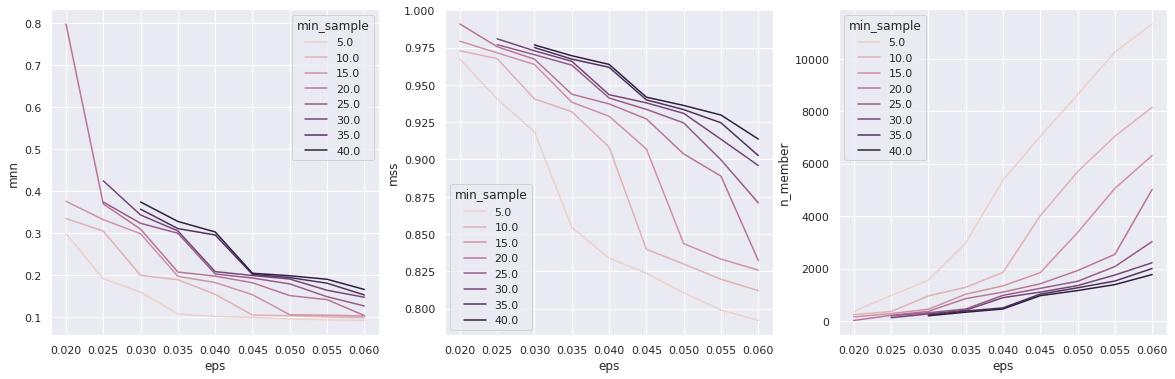

In [ ]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.lineplot(x='eps', y='mnn', hue = 'min_sample', data = mnn_df, legend = 'full')

plt.subplot(132)
sns.lineplot(x='eps', y='mss', hue = 'min_sample', data = mnn_df, legend = 'full')

plt.subplot(133)
sns.lineplot(x='eps', y='n_member', hue = 'min_sample', data = mnn_df, legend = 'full')

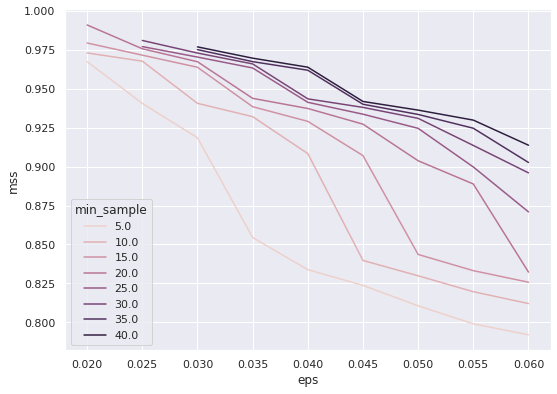

In [ ]:
sns.lineplot(x='eps', y='mss', hue = 'min_sample', data = mnn_df[mnn_df.mnn > 0], legend = 'full')

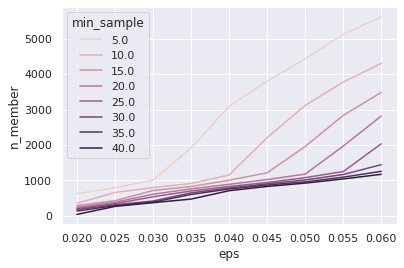

In [ ]:
sns.lineplot(x='eps', y='n_member', hue = 'min_sample', data = mnn_df, legend = 'full')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


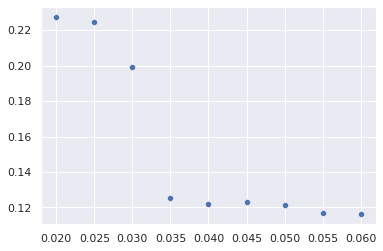

In [ ]:
# mnn_values [#eps, #min_sample]
import seaborn as sns
sns.scatterplot(eps, mnn_values[:, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


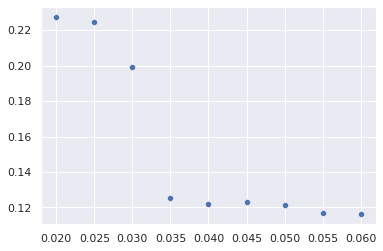

In [ ]:
sns.scatterplot(eps, mnn_values[:, 0])

In [ ]:
# fitting/training the model using the normalized features
db = DBSCAN(eps=0.055,min_samples=30).fit(scaled_features)

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

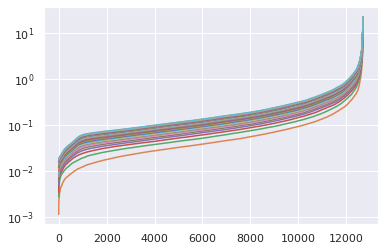

In [ ]:
plt.plot(distances)
plt.yscale('log')

(0.0, 1.0)

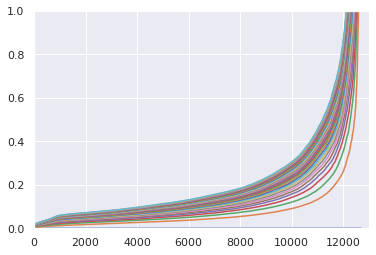

In [ ]:
plt.plot(distances)
plt.xlim([0,13000])
plt.ylim([0,1])

In [ ]:
len(scaled_features)

12705

In [ ]:
all_stars = all_stars_filtered.dropna(subset= ['pmra', 'pmdec', 'parallax'])

all_stars['labels'] = labels
all_stars['is_core'] = core_samples_mask
mask = all_stars.ruwe < 1.4


features['labels'] = labels

In [ ]:
len(core_samples_mask)

12705

In [ ]:
features # labels = -1 means they are noise points

,pmra,pmdec,parallax,labels
1,-7.692861,3.247277,0.414998,0
3,-7.790891,3.327559,0.380763,0
5,-6.289207,1.255207,0.909725,-1
6,-26.999138,30.756899,6.572804,-1
7,-4.619843,0.857460,0.429294,-1
...,...,...,...,...
52190,-4.996321,-0.374412,0.476776,-1
52191,-8.004699,0.837689,0.768053,-1
52193,-5.764603,3.085954,0.437348,-1
52195,-6.713566,3.033437,0.303683,0


In [ ]:
all_stars.iloc[:,-2:] # labels = -1 means they are noise points

,labels,is_core
1,0,True
3,0,True
5,-1,False
6,-1,False
7,-1,False
...,...,...
52190,-1,False
52191,-1,False
52193,-1,False
52195,0,False


In [ ]:
all_stars.labels.value_counts()

-1    11439
 0     1167
 2       56
 1       43
Name: labels, dtype: int64

In [ ]:
member_data = all_stars[all_stars.labels == 0]
mean_nearest_neighbor(member_data)

0.20681127432160543

Model | Eps | Min Pts | MNN Value | n(memb)
----|----|----|---|---
1 | 0.02| 5| 0.2275 | 627
2 | 0.02| 10 | 0.3185| 356
3 | 0.02| 15 | 0.3332| 293
4 | 0.02| 20 | 0.3592| 246
5 | 0.02| 25 | 0.3686| 210
6 | 0.02| 30 | 0.3808| 179
7 | 0.02| 35 | 0.4076| 137
8 | 0.02| 40 | 0.6610| 42
9 | 0.03| 5 | 0.1989 | 1010
10| 0.03| 10 | 0.2270| 799
11| 0.03| 15 | 0.2286| 716
12| 0.03| 20 | 0.2381| 612
13| 0.03| 25 | 0.2478| 538
14| 0.03| 30 | 0.3144| 420
15| 0.03| 35 | 0.3194| 388
16| 0.03| 40 | 0.3221| 373
17| 0.03| 45 | 0.3275| 349
18| 0.03| 50 | 0.3285| 340
19| 0.04| 5 | 0.1218 | 3090
20| 0.04| 10 | 0.2016| 1154
21| 0.04| 15 | 0.2128| 1006
22| 0.04| 20 | 0.2300| 891
23| 0.04| 25 | 0.2308| 830
24| 0.04| 30 | 0.2316| 787
25| 0.04| 35 | 0.2323| 760
26| 0.04| 40 | 0.2416| 711
27| 0.04| 45 | 0.2421| 677
28| 0.04| 50 | 0.2473| 632
29| 0.05| 5 | 0.1214 | 4431
30| 0.05| 10 | 0.1247| 3118
31| 0.05| 15 | 0.1297| 1958
32| 0.05| 20 | 0.2007| 1179
33| 0.05| 25 | 0.2168| 1080
34| 0.05| 30 | 0.2225| 1016
35| 0.05| 35 | 0.2260| 962
36| 0.05| 40 | 0.2263| 925
37| 0.05| 45 | 0.2281| 899
38| 0.05| 50 | 0.2290| 880

In [ ]:
# code to find the NMM autometically for a given range


(-6.0, 6.0)

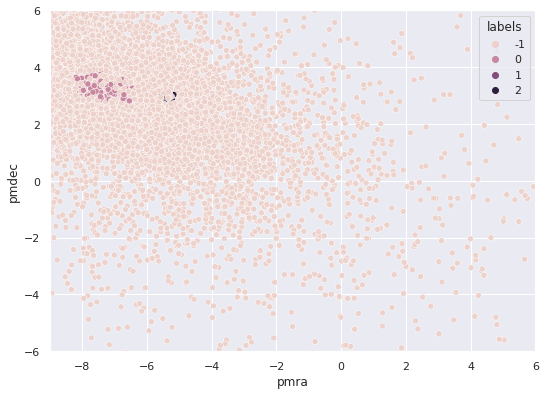

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8.7,6.27)})
features['label_string']=features['labels'].apply(str)

#sns.scatterplot(x='pmra', y='pmdec', data=features[features.labels > -1], hue='labels',legend='full')

sns.scatterplot(x='pmra', y='pmdec', data=features, hue='labels',legend='full')
plt.xlim([-9,6])
plt.ylim([-6,6])

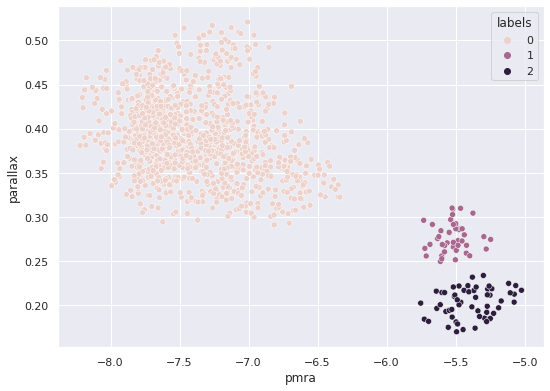

In [ ]:
sns.scatterplot(x='pmra', y='parallax', data=features[features.labels > -1], hue='labels',legend='full')

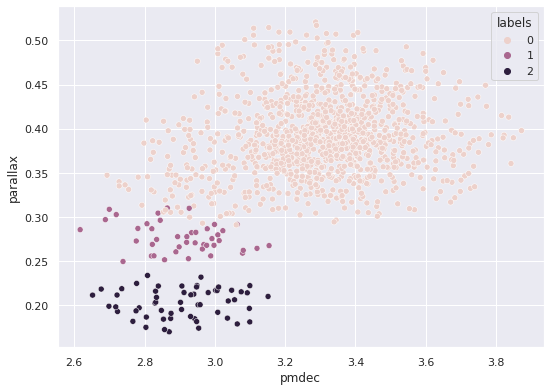

In [ ]:
sns.scatterplot(x='pmdec', y='parallax', data=features[features.labels > -1], hue='labels',legend='full')

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [ ]:
from sklearn import metrics

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 11439


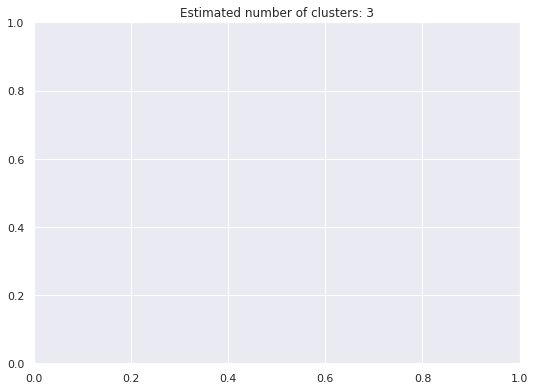

In [ ]:
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
features.labels.value_counts()

-1    11439
 0     1167
 2       56
 1       43
Name: labels, dtype: int64

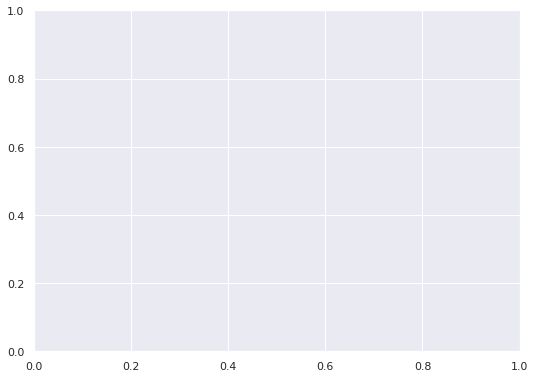

In [ ]:
sns.histplot()

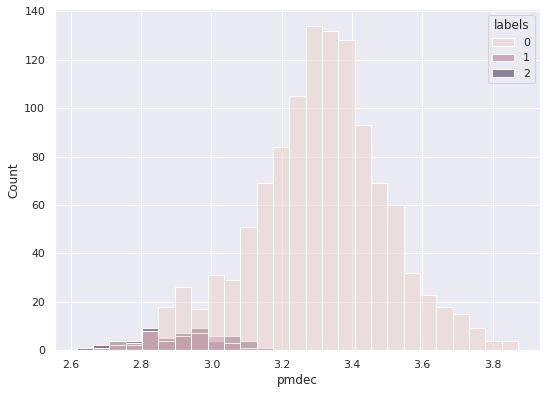

In [ ]:
sns.histplot(x='pmdec', data=features[features.labels > -1], hue='labels',legend='full')

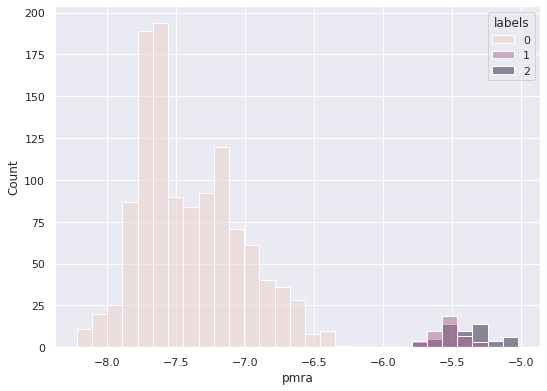

In [ ]:
sns.histplot(x='pmra', data=features[features.labels > -1], hue='labels',legend='full')

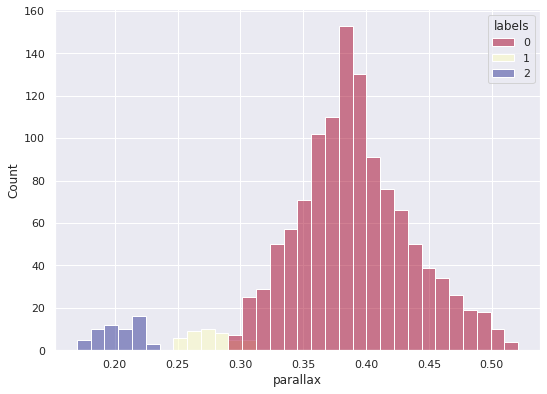

In [ ]:
sns.histplot(x='parallax', data=features[features.labels > -1], hue='labels',legend='full',palette='RdYlBu')

## Comparing with RF and Cantat

In [ ]:
rf_member = pd.read_csv('NGC_3293_all_member_prob.csv')
rf_member.head()

,Unnamed: 0,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,b,ecl_lon,ecl_lat,dist,pmra_over_error,pmdec_over_error,dist_3293_center,member,PMemb,dataset
0,18,1636042515805110273,Gaia EDR3 5351448509755017728,5351448509755017728,1538401452,2016.0,158.977705,0.016078,-58.230215,0.016784,...,0.077398,198.546933,-58.775885,0.004126,371.985550,167.590177,0.004132,1,0.927464,New_member
1,28,1636042515805110273,Gaia EDR3 5351448505437776896,5351448505437776896,1241332933,2016.0,158.964860,0.055362,-58.226442,0.054317,...,0.077317,198.532615,-58.778097,0.005308,98.770329,49.146132,0.005301,1,0.862039,New_member
2,34,1636042515805110273,Gaia EDR3 5351448509737580672,5351448509737580672,1765297140,2016.0,158.972310,0.058940,-58.225101,0.064636,...,0.080427,198.536044,-58.774352,0.006025,90.849389,41.551858,0.006023,1,0.919141,New_member
3,44,1636042515805110273,Gaia EDR3 5351448509754722688,5351448509754722688,484043063,2016.0,158.981488,0.050797,-58.234685,0.041382,...,0.074505,198.555790,-58.777578,0.007074,116.669088,71.018368,0.007082,1,0.925243,New_member
4,112,1636042515805110273,Gaia EDR3 5351447238427079936,5351447238427079936,1387637007,2016.0,158.951722,0.038953,-58.237376,0.033341,...,0.064391,198.538416,-58.790681,0.011547,166.762061,105.553345,0.011542,1,0.889732,New_member


In [ ]:
len(rf_member), len(rf_member[rf_member.dist < 1/3])

(2099, 1582)

In [ ]:
cantat_member = pd.read_csv('NGC_3293_cantat.csv')
cantat_member.head()

,Unnamed: 0,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,pmra_over_error,pmdec_over_error,PMemb
0,1,1636042515805110273,Gaia EDR3 5351448509755016832,5351448509755016832,1183214490,2016.0,158.970897,0.016117,-58.230469,0.016379,...,NaN,NaN,285.860228,0.075398,198.542458,-58.778630,0.000710,350.655675,177.128301,0.6
1,3,1636042515805110273,Gaia EDR3 5351448505437778944,5351448505437778944,252212049,2016.0,158.969394,0.018871,-58.229695,0.018958,...,NaN,NaN,285.859156,0.075678,198.540324,-58.778657,0.001350,317.018587,161.841089,1.0
2,19,1636042515805110273,Gaia EDR3 5351448505437777280,5351448505437777280,1517365628,2016.0,158.965519,0.016377,-58.227545,0.015643,...,NaN,NaN,285.856318,0.076531,198.534606,-58.778618,0.004191,380.930663,193.735292,0.7
3,43,1636042515805110273,Gaia EDR3 5351448509754721024,5351448509754721024,791288038,2016.0,158.980902,0.016169,-58.235119,0.017190,...,NaN,NaN,285.867108,0.073975,198.555975,-58.778102,0.007056,351.532407,170.795313,0.8
4,45,1636042515805110273,Gaia EDR3 5351447032286265728,5351447032286265728,162676582,2016.0,158.960877,0.018613,-58.236293,0.019044,...,NaN,NaN,285.858538,0.067724,198.543407,-58.786473,0.007149,304.436263,142.253038,1.0


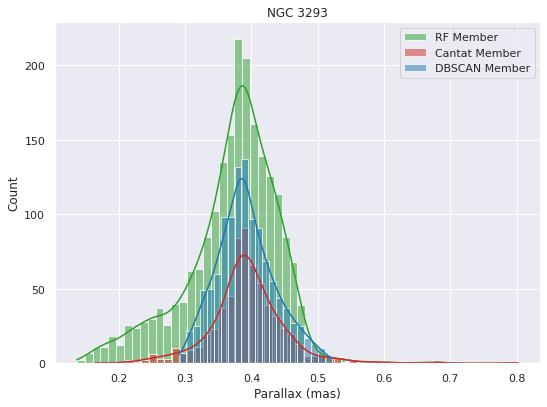

In [ ]:
sns.histplot(x='parallax', data=rf_member, label='RF Member',
             kde=True,color='tab:green')
sns.histplot(x='parallax', data=cantat_member,
              kde=True,color='tab:red', label='Cantat Member')
sns.histplot(x='parallax', data=features[features.labels == 0],
              kde=True,color='tab:blue', label='DBSCAN Member')
plt.title('NGC 3293')
plt.xlabel('Parallax (mas)')
plt.legend()
plt.show()

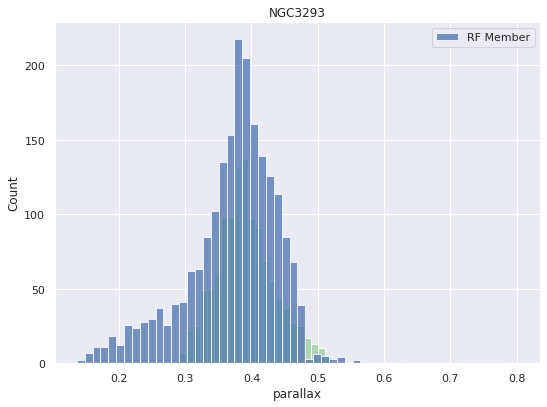

In [ ]:
sns.histplot(x='parallax', data=features[features.labels == 0],hue='labels',legend='full',palette='Greens').set(title='NGC3293')
sns.histplot(x='parallax', data=rf_member, label='RF Member',legend='full',palette='Blues')
plt.legend()

In [ ]:
members=all_stars[all_stars.labels==0]

In [ ]:
np.median(members.parallax)

0.3878173408220792

In [ ]:
np.std(members.parallax)

0.04388153591762714

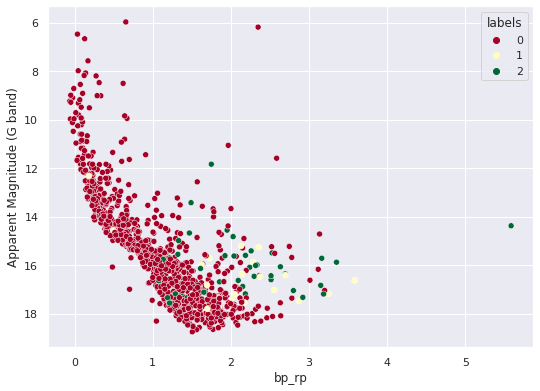

In [ ]:
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
                data = all_stars[all_stars.labels > -1], hue = 'labels')
plt.ylabel('Apparent Magnitude (G band)')
#plt.xlim(0,3)
#sns.scatterplot(hr.b_v+0.5, hr.V+10)

plt.gca().invert_yaxis()

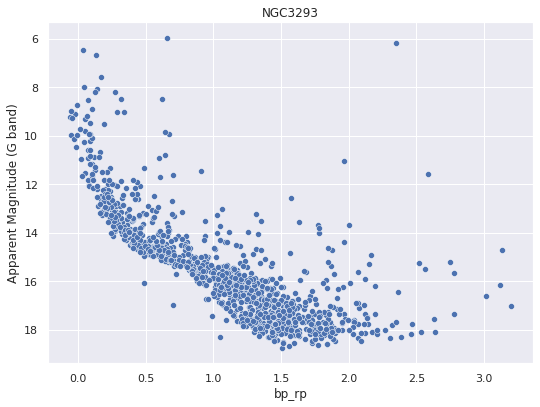

In [ ]:
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='Greens',
                data = all_stars[all_stars.labels == 0]).set(title='NGC3293')
plt.ylabel('Apparent Magnitude (G band)')
#plt.xlim(0,3)
#sns.scatterplot(hr.b_v+0.5, hr.V+10)

plt.gca().invert_yaxis()

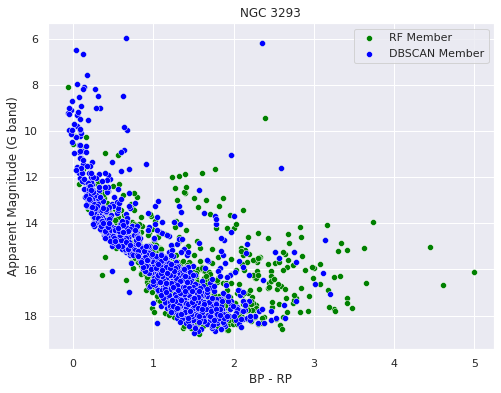

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',
                data = rf_member, label = 'RF Member', color='green')
#sns.scatterplot(x = 'bp-rp', y='Gmag',
                #data = cantat_member, label = 'Cantat Member', color='red')
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',
                data = all_stars[all_stars.labels == 0],
                label = 'DBSCAN Member', color='blue')
plt.title('NGC 3293')
plt.ylabel('Apparent Magnitude (G band)')
plt.xlabel('BP - RP')

plt.gca().invert_yaxis()

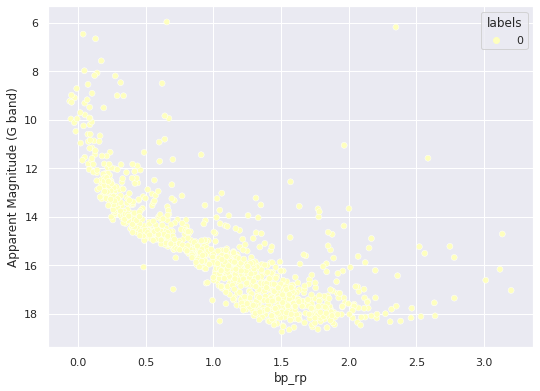

In [ ]:
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag',palette='RdYlGn',
                data = all_stars[all_stars.labels == 0], hue = 'labels')
plt.ylabel('Apparent Magnitude (G band)')
#plt.xlim(0,3)
#sns.scatterplot(hr.b_v+0.5, hr.V+10)

plt.gca().invert_yaxis()

In [ ]:
all_stars.groupby('labels').parallax.std()

labels
-1    0.559086
 0    0.043900
 1    0.016635
 2    0.016353
Name: parallax, dtype: float64

In [ ]:
all_stars.shape

(12705, 156)

In [ ]:
feature_columns = ['parallax', 'pmra', 'pmdec']

sample = all_stars.sample(5000)
sample = sample.reset_index(drop=True)
sample.head()

,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist,g_mag_error,labels,is_core
0,1636148068921376768,Gaia DR3 5351454312231871744,5351454312231871744,612016101,2016.0,158.624191,0.084216,-58.049593,0.075345,0.423663,...,0.0058,0.1638,0.0147,0.0031,0.0871,PHOENIX,0.257353,0.001193,-1,False
1,1636148068921376768,Gaia DR3 5351438030034766592,5351438030034766592,1328771891,2016.0,158.853372,0.008878,-58.461203,0.009283,0.433357,...,NaN,NaN,NaN,NaN,NaN,,0.238198,0.000144,0,False
2,1636148068921376768,Gaia DR3 5351443866868225280,5351443866868225280,1722881004,2016.0,158.471398,0.060275,-58.290399,0.063405,0.243485,...,4.4049,4.4785,2.4665,2.4580,2.5003,A,0.268939,0.000877,-1,False
3,1636148068921376768,Gaia DR3 5351442221921910912,5351442221921910912,1057677591,2016.0,158.538504,0.053090,-58.385921,0.056900,0.346473,...,0.2297,0.2882,0.1391,0.1237,0.1552,MARCS,0.274568,0.000727,-1,False
4,1636148068921376768,Gaia DR3 5351453040921538944,5351453040921538944,1733801146,2016.0,158.794809,0.119004,-58.114698,0.112133,0.716588,...,0.0121,0.0772,0.0197,0.0065,0.0417,MARCS,0.148539,0.002240,-1,False


In [ ]:
sample_features = sample.loc[:, feature_columns]
sample_features = sample_features.dropna(axis=0)
sample_features = sample_features.reset_index(drop=True)
sample_features.head()

,parallax,pmra,pmdec
0,0.423663,-4.957548,2.434121
1,0.433357,-7.581601,3.720831
2,0.243485,-4.317025,3.247772
3,0.346473,-5.999055,3.428036
4,0.716588,-8.011894,3.126114


In [ ]:
scaled_features = pd.DataFrame({})
for column in sample_features.columns:
    print(np.std(sample_features[column]))
    scaled_features[column] = (sample_features[column] - np.median(sample_features[column]))/np.std(sample_features[column])
scaled_features.head()

0.5587404602814403
5.357161108847852
3.926317340988982


,parallax,pmra,pmdec
0,-0.120356,0.374366,-0.174375
1,-0.103007,-0.115456,0.153339
2,-0.442827,0.493930,0.032855
3,-0.258507,0.179952,0.078766
4,0.403903,-0.195777,0.001869


In [ ]:
min(all_stars_filtered['phot_g_mean_mag'])

5.973090171813965

In [ ]:
dist = np.zeros(len(scaled_features), dtype = object)
for i in range(len(scaled_features)):
    current_point = scaled_features.iloc[i]
    other_point = scaled_features.drop([i])
    
    dist_square = 0
    for col in scaled_features.columns:
        dist_square += (other_point[col] - current_point[col])**2
     
    dist[i] = np.array(sorted(np.sqrt(dist_square)))

In [ ]:
k_dist = np.stack(dist)

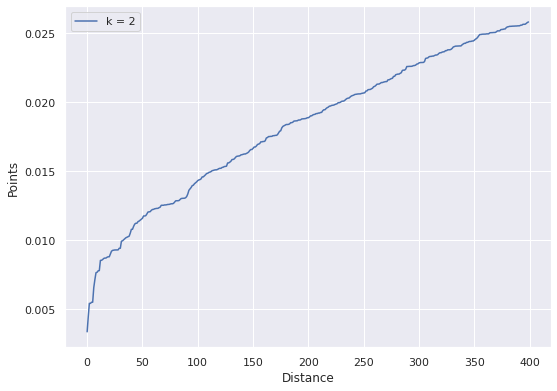

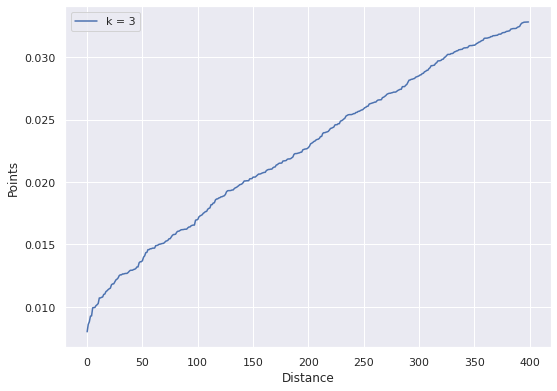

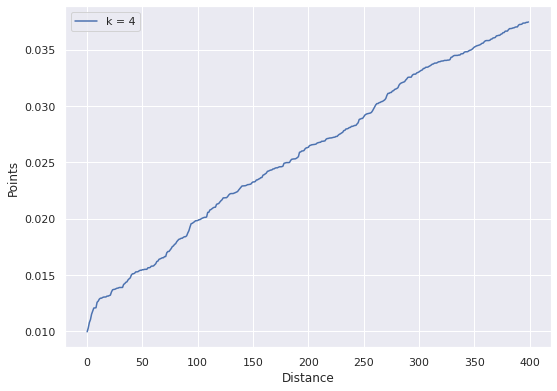

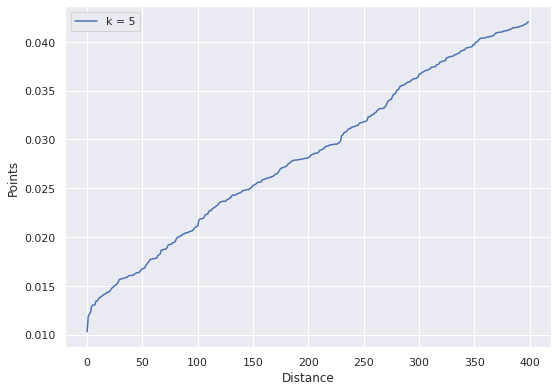

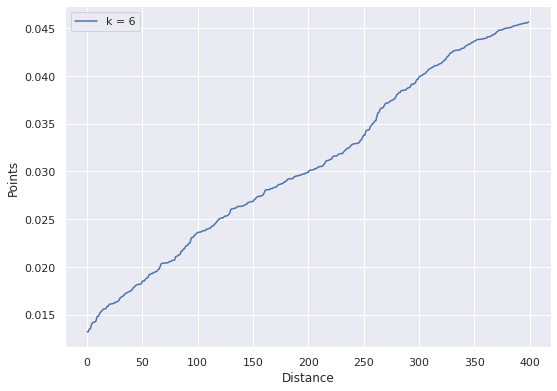

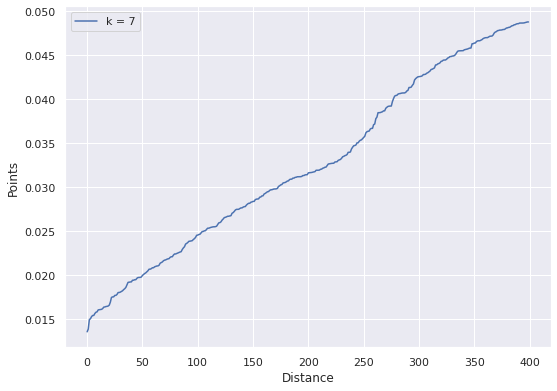

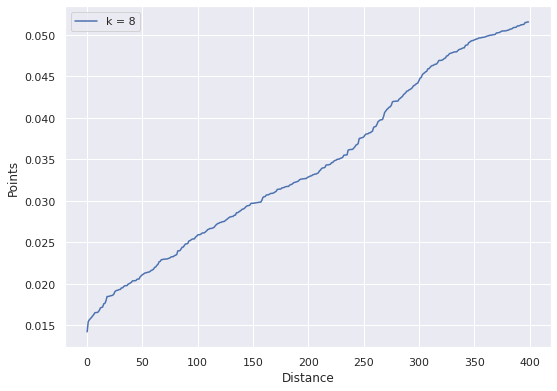

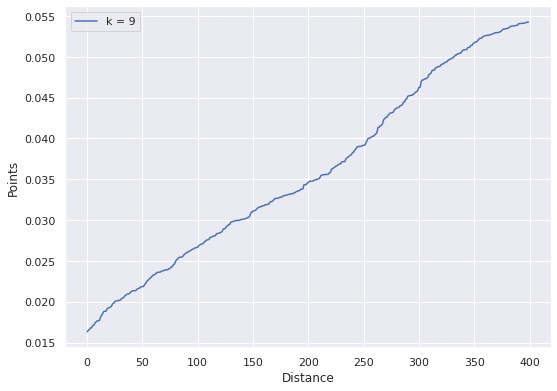

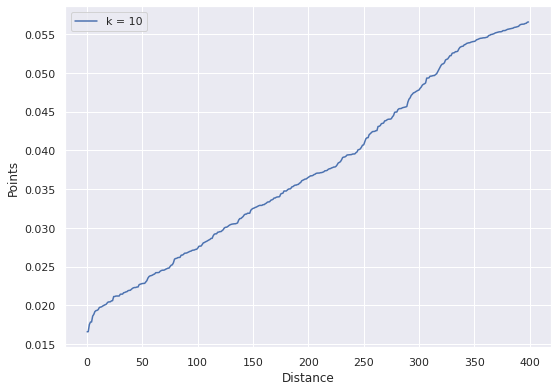

In [ ]:
for i in range(1, 10, 1):    
    plt.plot(sorted(k_dist[:, i])[:400], label=f'k = {i+1}')
    plt.legend()
    plt.xlabel('Distance')
    plt.ylabel('Points')
    plt.show()